<a href="https://colab.research.google.com/github/Sylvariane/prediction_revenus/blob/main/P07_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prédiction de revenus

## 0. Préparation de l'environnement de travail

In [1]:
## connexion à Google Drive pour importer les dossiers
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
## importation des librairies nécessaires

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
## définition des caractéristiques pour les graphiques

sns.set_context('talk')
sns.set_palette('Set1')

In [4]:
def lorenz_curve(X):
  """ Fonction qui trace la courbe de Lorenz d'une variable donnée.
  Il prend comme argument un objet de type array (numpy)
  """
  X_lorenz = np.cumsum(np.sort(X)) / X.sum()
  X_lorenz = np.insert(X_lorenz, 0, 0) 
  X_lorenz[0], X_lorenz[-1]
  fig, ax = plt.subplots(figsize=[10,10])
  ## scatter plot of Lorenz curve
  _ = ax.plot(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, color='red', label=i)
  _ = ax.plot([0,1], [0,1], color='k', label='bissectrice')
  _ = plt.title('Courbe de Lorenz de ' + i)
  _ = plt.legend()
  _ = plt.show()

In [5]:
# chargement des données nécessaires au projet
data = pd.read_csv('/content/drive/My Drive/Data Analyst - OC/Projets/P7_guillot_cecile/world_income_distribution.csv')
data.head()

,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp
0,ALB,2008,1,100,728.89795,0.03143,7297.0
1,ALB,2008,2,100,916.66235,0.03143,7297.0
2,ALB,2008,3,100,1010.91600,0.03143,7297.0
3,ALB,2008,4,100,1086.90780,0.03143,7297.0
4,ALB,2008,5,100,1132.69970,0.03143,7297.0


In [6]:
print('Valeurs manquantes :\n' + str(data.isnull().sum()))

Valeurs manquantes :
country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
pop               0
gdpppp          200
dtype: int64


In [7]:
print('Valeurs dupliquées : ', data.duplicated().sum())

Valeurs dupliquées :  0


## 1. Résumé des données

**Mission 1**


Résumez les données utilisées :
- Année(s) des données utilisées ;
- Nombre de pays présents ;
- Population couverte par l'analyse (en termes de pourcentage de la population mondiale).

In [8]:
year_survey = data['year_survey'].unique()
print(np.sort(year_survey))

[2004 2006 2007 2008 2009 2010 2011]


In [9]:
country = data['country'].unique()
print('Nombre de pays présents dans l\'échantillon : ', len(country))
print('Liste des pays présents dans l\'échantillon : \n', country)

Nombre de pays présents dans l'échantillon :  116
Liste des pays présents dans l'échantillon : 
 ['ALB' 'ARG' 'ARM' 'AUT' 'AZE' 'BEL' 'BFA' 'BGD' 'BGR' 'BIH' 'BLR' 'BOL'
 'BRA' 'BTN' 'CAF' 'CAN' 'CHL' 'CHN' 'CIV' 'CMR' 'COL' 'CRI' 'CYP' 'CZE'
 'DEU' 'DNK' 'DOM' 'ECU' 'EGY' 'ESP' 'EST' 'FIN' 'FJI' 'FRA' 'GBR' 'GEO'
 'GHA' 'GIN' 'GRC' 'GTM' 'HND' 'HRV' 'HUN' 'IDN' 'IND' 'IRL' 'IRN' 'IRQ'
 'ISL' 'ISR' 'ITA' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM' 'KOR' 'XKX' 'LAO'
 'LBR' 'LKA' 'LTU' 'LUX' 'LVA' 'MAR' 'MDA' 'MDG' 'MEX' 'MKD' 'MLI' 'MNE'
 'MNG' 'MOZ' 'MRT' 'MWI' 'MYS' 'NER' 'NGA' 'NIC' 'NLD' 'NOR' 'NPL' 'PAK'
 'PAN' 'PER' 'PHL' 'POL' 'PRT' 'PRY' 'ROU' 'RUS' 'SDN' 'SLV' 'SRB' 'SVK'
 'SVN' 'SWE' 'SWZ' 'SYR' 'THA' 'TJK' 'TLS' 'TUR' 'TWN' 'TZA' 'UGA' 'UKR'
 'URY' 'USA' 'VEN' 'VNM' 'PSE' 'YEM' 'ZAF' 'COD']


In [10]:
# Chargement du tableau avec les codes ISO et les pays
country_iso = pd.read_csv('/content/drive/My Drive/Data Analyst - OC/Projets/P7_guillot_cecile/sql-pays.csv', header=None)

In [11]:
# Renommage des colonnes pour conserver celle qui nous intéresse
country_iso.columns = ['0', '1', '2', 'iso_code', 'Country', '5']
country_iso = country_iso[['iso_code', 'Country']]

In [12]:
# Fusion des deux DataFrame pour obtenir le nom du pays en fonction de son code ISO
data = pd.merge(data, country_iso, left_on='country', right_on='iso_code')
data = data[['iso_code', 'Country', 'year_survey', 'quantile', 'nb_quantiles', 'income', 'pop', 'gdpppp']]
data = data.rename(columns={"Country":'country'})
data.head()

,iso_code,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp
0,ALB,Albanie,2008,1,100,728.89795,0.03143,7297.0
1,ALB,Albanie,2008,2,100,916.66235,0.03143,7297.0
2,ALB,Albanie,2008,3,100,1010.91600,0.03143,7297.0
3,ALB,Albanie,2008,4,100,1086.90780,0.03143,7297.0
4,ALB,Albanie,2008,5,100,1132.69970,0.03143,7297.0


In [13]:
# Chargement des données contenant le nombre d'habitants par pays pour l'année 2008
pop_fao = pd.read_csv('/content/drive/My Drive/Data Analyst - OC/Projets/P7_guillot_cecile/population_2008.csv')

In [14]:
# Fusion des dataframes pour avoir le nombre d'habitants par pays
pop_fao  = pop_fao[['Zone', 'Valeur']]
pop_fao['Valeur'] = pop_fao['Valeur'] * 1000
data = pd.merge(data, pop_fao, right_on='Zone', left_on='country')

In [15]:
# Calcul du nombre d'habitants présents dans l'échantillon
# Transformation en pourcentage
pop_total = sum(pop_fao['Valeur'])
pop_data = data['Valeur'].groupby(data['country']).mean()
pourcent_pop_ech = round((pop_data.sum()/pop_total) * 100, 2)
print('Population couverte par l\'analyse : ' + str(pourcent_pop_ech) + '%.')

Population couverte par l'analyse : 84.14%.


In [16]:
data = data[['iso_code', 'country', 'year_survey', 'quantile', 'nb_quantiles', 'income', 'pop', 'gdpppp']]

In [17]:
# Suppression des dataframes non utiles à la suite de l'étude
del pop_fao
del country_iso

- De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?
- Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?

Pour chaque pays, les revenus sont présentés sous la forme de centiles. On dispose de 100 classes de revenus par pays. L'avantage de ce découpage permet de gommer les écarts entre les pays. De plus, on va avoir tendance à voir moins de valeurs qui vont être influencés par des valeurs aberrantes comme cela serait le cas pour une moyenne par exemple.

**Définition de méthode Eltöte-Köves-Szulc** : il s'agit d'une méthode statistique qui permet de calculer la parité de pouvoir d'achat. Elle a l'avantage de donner un poids à chaque pays et ainsi favoriser la comparaison entre différents pays.

## 2. Distribution des richesses dans notre échantillon

Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.



In [18]:
# Choix de 10 pays pour la suite de l'analyse
data = data.set_index('iso_code')
df = data.loc(axis=0)['FRA', 'BEL','EST', 'ARM', 'GEO', 'ARG', 'ECU', 'PAN', 'ISL', 'POL', 'RUS'].reset_index()
df = df.sort_values('iso_code')

In [19]:
# modification de la classe de 'income'
# création de la classe 'income_log10'
df['income'] = df['income'].apply(lambda x: float(x))
df['income_log10'] = df['income'].apply(lambda x: math.log10(x)) 
df.head()

,iso_code,country,year_survey,quantile,nb_quantiles,income,pop,gdpppp,income_log10
549,ARG,Argentine,2008,50,100,4132.6655,0.398761,13220.0,3.616230
573,ARG,Argentine,2008,74,100,6995.5570,0.398761,13220.0,3.844822
572,ARG,Argentine,2008,73,100,6826.5220,0.398761,13220.0,3.834199
571,ARG,Argentine,2008,72,100,6696.6587,0.398761,13220.0,3.825858
570,ARG,Argentine,2008,71,100,6600.3413,0.398761,13220.0,3.819566


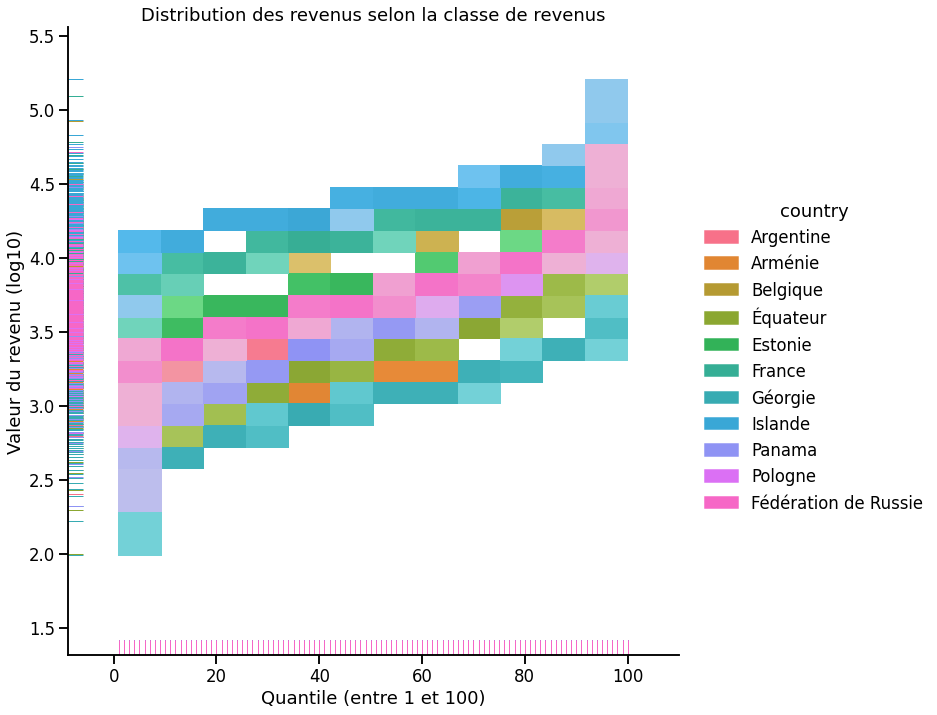

In [20]:
# Affichage de la distribution des revenus en fonction de la classe de revenus
_ = sns.displot(x='quantile', y='income_log10', hue='country', rug=True, height=10, data=df)
_ = plt.title('Distribution des revenus selon la classe de revenus')
_ = plt.xlabel('Quantile (entre 1 et 100)')
_ = plt.ylabel('Valeur du revenu (log10)')
_ = plt.show()

Représentez la courbe de Lorenz de chacun des pays choisis.

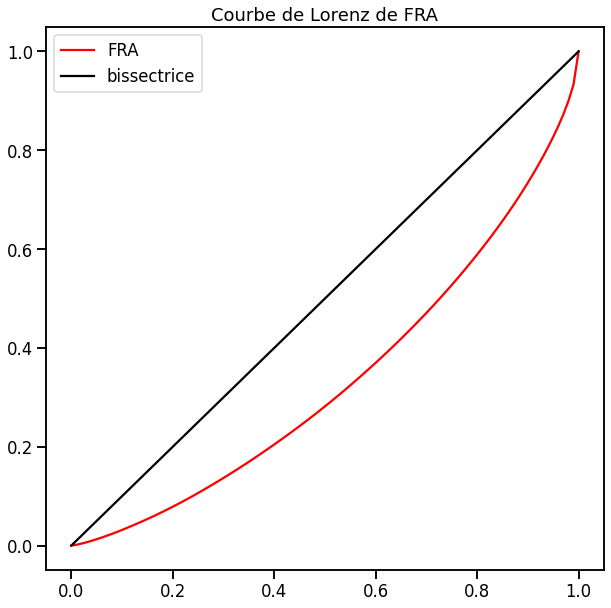

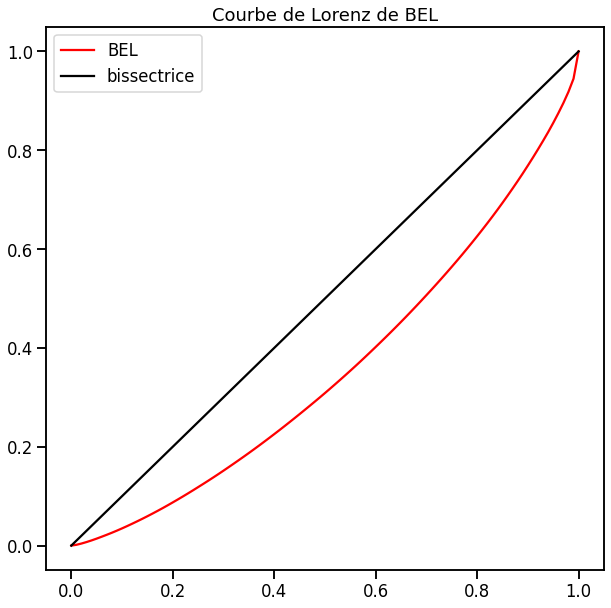

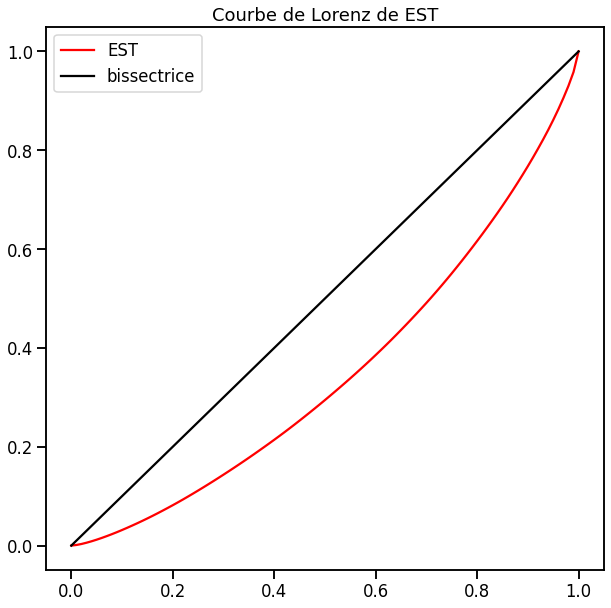

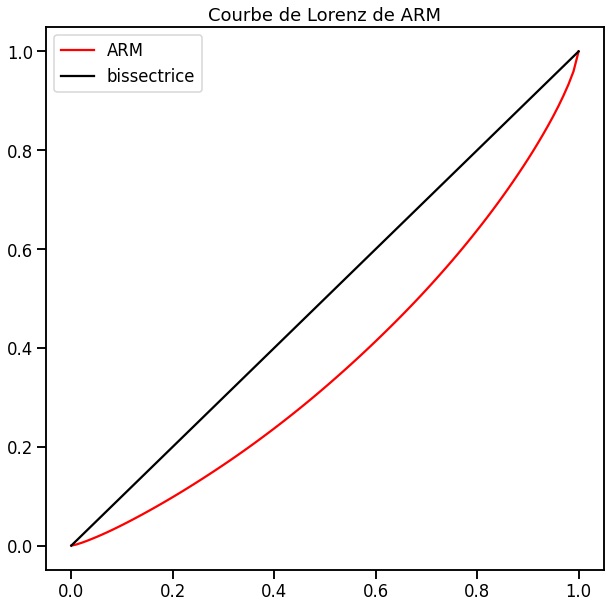

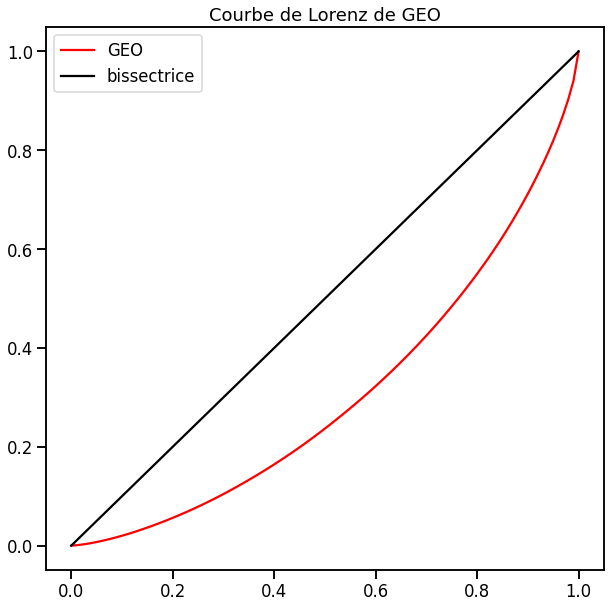

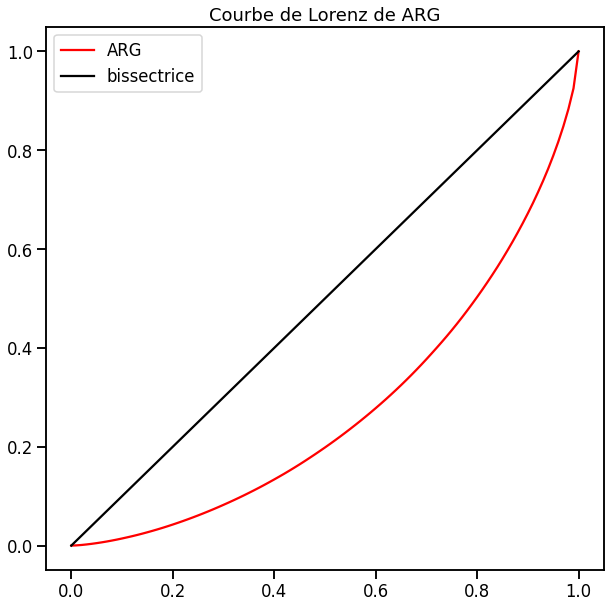

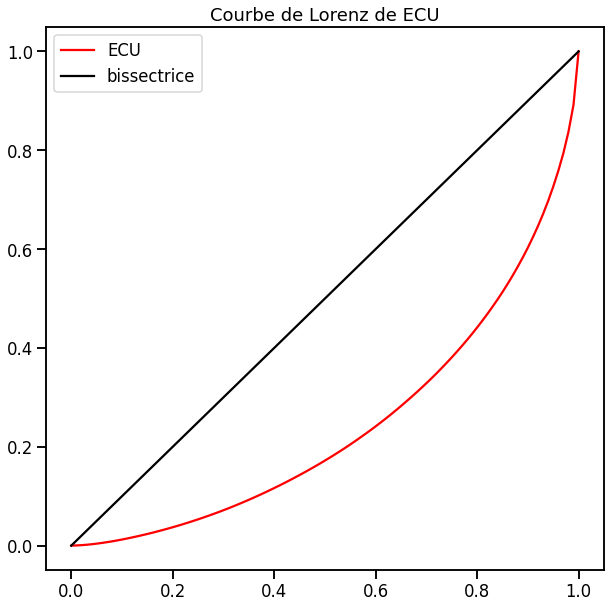

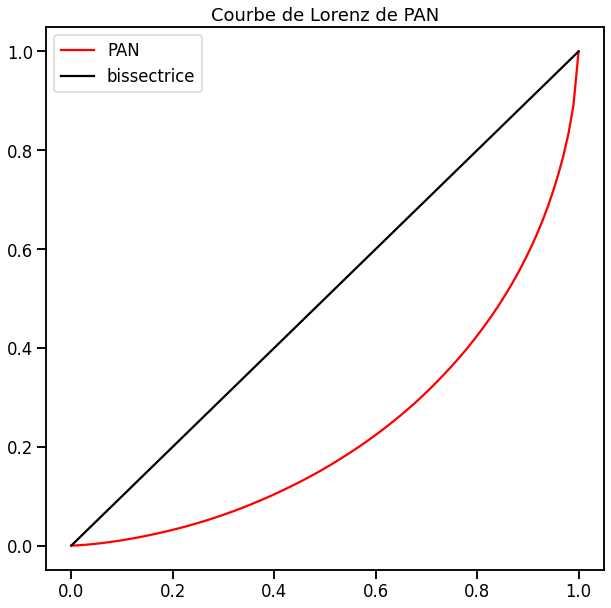

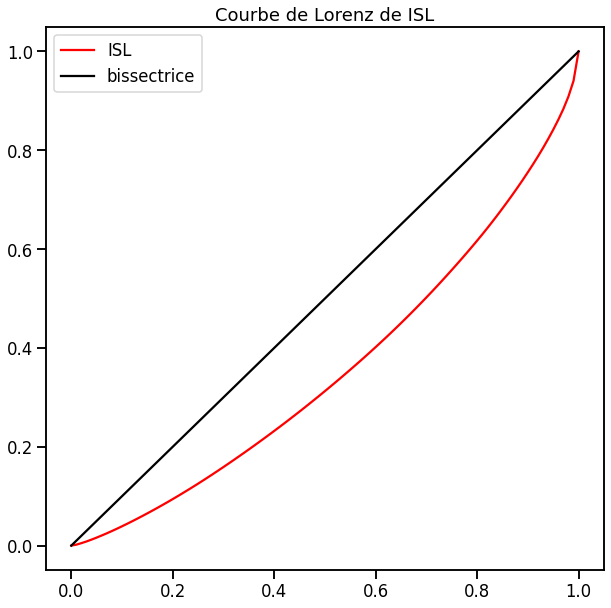

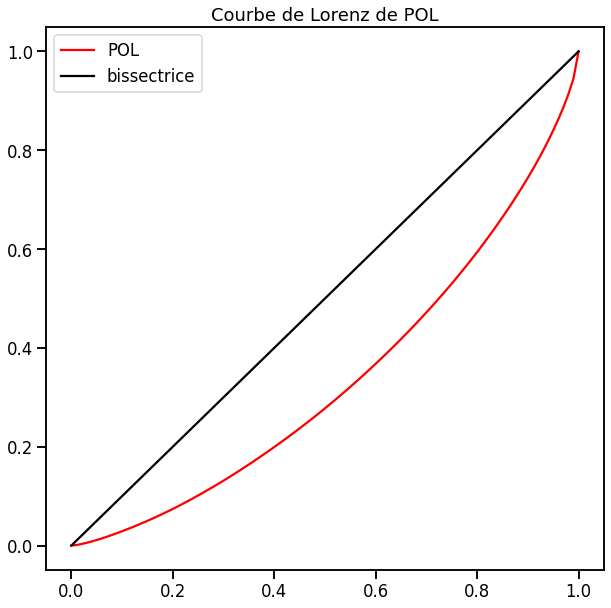

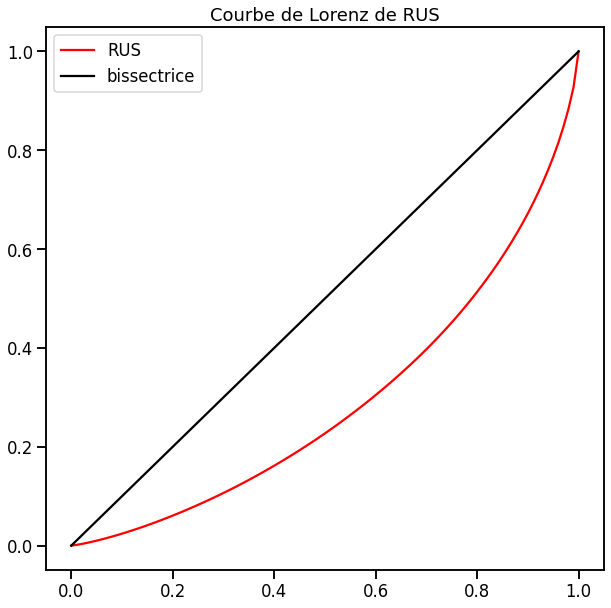

In [21]:
# Création d'une boucle pour tracer les courbes de Lorenz de chaque pays
code_iso = ['FRA', 'BEL','EST', 'ARM', 'GEO', 'ARG', 'ECU', 'PAN', 'ISL', 'POL', 'RUS']

for i in code_iso:
  arr = df.loc[df['iso_code'] == i]['income']
  X = np.array(arr)
  lorenz_curve(X)

Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.

In [22]:
# Chargement des indices de Gini provenant de la banque mondiale
gini_index = pd.read_csv('/content/drive/My Drive/Data Analyst - OC/Projets/P7_guillot_cecile/gini_index.csv', sep=',')

In [23]:
# Sélection des pays retenus pour la démonstration
gini_index = gini_index.set_index('Country Code')
gini_index = gini_index.loc(axis=0)['FRA', 'BEL','EST', 'ARM', 'GEO', 'ARG', 'ECU', 'PAN', 'ISL', 'POL', 'RUS']

In [24]:
# Sélection des indices de Gini pour les années de notre échantillon
gini_index = gini_index[['2004', '2006', '2007', '2008', '2009', '2010','2011']]
gini_index

,2004,2006,2007,2008,2009,2010,2011
Country Code,,,,,,,
FRA,30.6,29.7,32.4,33.0,32.7,33.7,33.3
BEL,30.5,28.1,29.2,28.4,28.6,28.4,28.1
EST,33.6,33.7,31.2,31.9,31.4,32.0,32.5
ARM,37.5,29.7,31.2,29.2,28.0,30.0,29.4
GEO,36.2,36.9,38.1,38.5,38.2,39.5,39.6
ARG,48.6,46.7,46.6,45.3,44.1,44.5,42.7
ECU,53.9,52.2,53.3,49.7,48.4,48.7,45.9
PAN,54.8,54.6,52.7,52.7,51.8,51.6,51.3
ISL,28.0,30.2,29.5,31.8,28.7,26.2,26.8


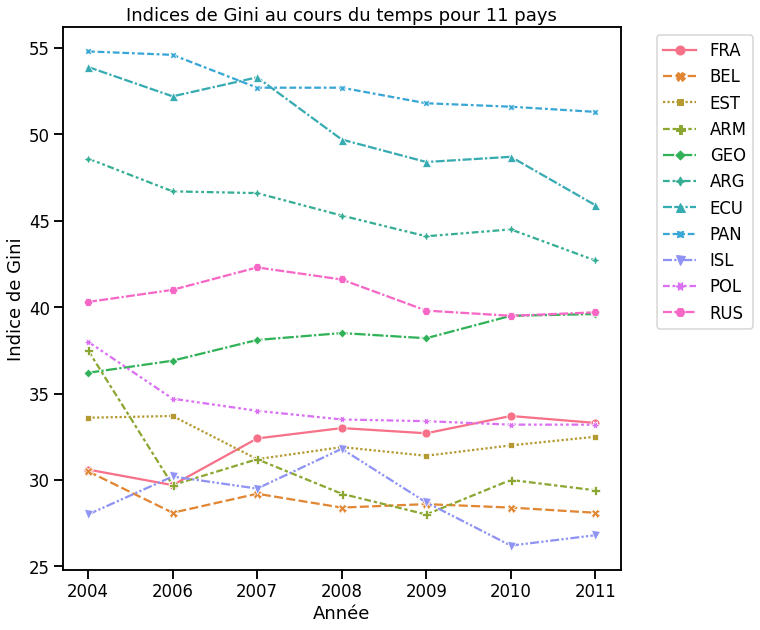

In [25]:
# Représentation graphique des indices de Gini pour nos différents pays
gini_T = gini_index.T


_ = plt.figure(figsize=(10,10))
_ = sns.lineplot(data=gini_T, markers=True)
_ = plt.title('Indices de Gini au cours du temps pour 11 pays')
_ = plt.xlabel('Année')
_ = plt.ylabel('Indice de Gini')
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

_ = plt.show()

Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?

In [26]:
gini_T.describe()

Country Code,FRA,BEL,EST,ARM,GEO,ARG,ECU,PAN,ISL,POL,RUS
count,7.00000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,32.20000,28.757143,32.328571,30.714286,38.142857,45.500000,50.300000,52.785714,28.742857,34.285714,40.600000
std,1.48324,0.854122,0.996183,3.141352,1.252806,1.962142,2.928595,1.411180,1.950946,1.722816,1.064581
min,29.70000,28.100000,31.200000,28.000000,36.200000,42.700000,45.900000,51.300000,26.200000,33.200000,39.500000
25%,31.50000,28.250000,31.650000,29.300000,37.500000,44.300000,48.550000,51.700000,27.400000,33.300000,39.750000
50%,32.70000,28.400000,32.000000,29.700000,38.200000,45.300000,49.700000,52.700000,28.700000,33.500000,40.300000
75%,33.15000,28.900000,33.050000,30.600000,39.000000,46.650000,52.750000,53.650000,29.850000,34.350000,41.300000
max,33.70000,30.500000,33.700000,37.500000,39.600000,48.600000,53.900000,54.800000,31.800000,38.000000,42.300000


Classement du plus petit au plus grand : Albanie, Allemagne, France, Canada, Georgie, Thaïlande, Philippines, Colombie, Honduras et Brésil.

La France fait partie des pays ayant l'indice de Gini le moins élevé ce qui montre une répartition de la richesse plutôt égale pour ce pays. 

## 3. Calcul de la classe de revenu des parents

In [27]:
gini_index = gini_index.reset_index()
gini_index = gini_index[['Country Code','2004', '2006', '2007', '2008', '2009', '2010','2011']]
data = pd.merge(data, gini_index, left_on = 'iso_code', right_on='Country Code')

In [28]:
del gini_index

In [29]:
data = data[['Country Code', 'country', 'year_survey', 'nb_quantiles', 'income', 'gdpppp',  '2008', 'pop']]
data = data.rename(columns={'Country Code':'iso_code',
                            '2008' : 'gini_index'})
data.head()

,iso_code,country,year_survey,nb_quantiles,income,gdpppp,gini_index,pop
0,ARG,Argentine,2008,100,254.08942,13220.0,45.3,0.398761
1,ARG,Argentine,2008,100,470.50150,13220.0,45.3,0.398761
2,ARG,Argentine,2008,100,623.45420,13220.0,45.3,0.398761
3,ARG,Argentine,2008,100,734.97455,13220.0,45.3,0.398761
4,ARG,Argentine,2008,100,832.31850,13220.0,45.3,0.398761


**Mission 3** : Dans l'état actuel, nous avons à disposition deux des trois variables explicatives souhaitées :
- le revenu moyen du pays
- l'indice de Gini du pays

Il nous manque donc, pour un individu : la classe de revenu de ses parents.

Pour chaque pays, nous allons utiliser une génération aléatoire de la classe de revenu des parents, à partir de ces seules deux informations :
- rho
- la classe de revenu de l'enfant.


In [30]:
elasticity_coeff = pd.read_csv('/content/drive/My Drive/Data Analyst - OC/Projets/P7_guillot_cecile/GDIMMay2018.csv')
elasticity_coeff.head()

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,cohort,parent,child,obs,P1,P2,P3,P4,P5,C1,C2,C3,C4,C5,MEANp,MEANc,SDp,SDc,GINIp,GINIc,IGP,NL1,NL2,COR,MAcatM,MAcatC1,Q4_IGpri,BHQ1,BHQ2,BHQ3,BHQ4,Q4BH,Q4child,Delta50,Asher_Q4_IGpri,ThreeGen_obs,ThreeGen_IGPp1,ThreeGen_IGPg1,ThreeGen_IGPgsd,All2125_MEANp,All2125_MEANc,All2125_IGP,All2125_MAcatC1,Cores2125_MEANp,Cores2125_MEANc,Cores2125_IGP,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,1980,avg,all,3956.0,0.666125,0.098583,0.170931,0.043031,0.021330,0.511857,0.025805,0.164191,0.183469,0.114678,2.480162,5.582401,3.809782,5.857765,0.728547,0.569981,0.802107,1.078013,-0.025322,0.521676,0.416691,0.414355,0.573748,0.341912,0.325161,0.209395,0.123532,0.162255,0.250311,3.408008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,1980,avg,daughter,721.0,0.615321,0.099272,0.212776,0.051969,0.020662,0.628481,0.023378,0.099265,0.132322,0.116553,2.989992,4.331731,4.010379,5.902685,0.675526,0.681604,0.848156,0.904866,-0.005200,0.576251,0.284895,0.283075,0.493111,0.434127,0.390918,0.101283,0.073671,0.285185,0.214735,1.859528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,1980,avg,son,3235.0,0.678699,0.098412,0.160574,0.040819,0.021495,0.482992,0.026405,0.180261,0.196128,0.114214,2.353979,5.891941,3.748495,5.806141,0.741541,0.541870,0.807674,1.168599,-0.033091,0.521442,0.449310,0.446874,0.599971,0.322116,0.311027,0.232628,0.134229,0.122268,0.259117,3.740587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.1
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,1980,dad,all,4137.0,0.686581,0.047610,0.057309,0.150907,0.057594,0.514562,0.026047,0.165638,0.181551,0.112202,3.756049,5.538275,5.493762,5.842035,0.713742,0.572566,0.514428,0.578723,-0.004792,0.483760,0.354333,0.350244,0.548029,0.334443,0.317131,0.219586,0.128840,0.192434,0.250295,3.538447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.1
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,1980,dad,daughter,744.0,0.639092,0.052328,0.054086,0.190100,0.064394,0.630354,0.022781,0.103736,0.129553,0.113576,4.520877,4.277768,5.804775,5.869737,0.660039,0.684751,0.491792,0.553255,-0.004494,0.486349,0.235170,0.230126,0.454504,0.429996,0.385429,0.104363,0.080212,0.339629,0.212542,1.974941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.1


1. Générez un grand nombre \(n\) de réalisations d'une variable que nous appellerons  \(ln(Y_{parent})\) selon une loi normale. Le choix de la moyenne et de l'écart type n'auront pas d'incidence sur le résultat final. \(n\) doit être supérieur à 1000 fois le nombre de quantiles.
2. Générez \(n\) réalisations du terme d'erreur \(\epsilon\) selon une loi normale de moyenne 0 et d'écart type 1.
3. Pour une valeur donnée de \(\rho_j\) (par exemple 0.9), calculez \(y_{child} = e^{\alpha+\rho_jln(y_{parent})+\epsilon}\) . Le choix de \( \alpha\) n'a aucune incidence sur le résultat final et peut être supprimé. À ce stade, \(y_{child}\) contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite.
4. Pour chacun des \(n\) individus générés, calculez la classe de revenu  \(c_{i,child}\) ainsi que la classe de revenu de ses parents \(c_{i,parent}\) , à partir de \(y_{child}\) et \(y_{parent}\).
5. À partir de cette dernière information, estimez pour chaque  \(c_{i,child}\) la distribution conditionnelle de \(c_{i,parent}\) . Par exemple, si vous observez 6 individus ayant à la fois  \(c_{i,child} = 5\) et \(c_{i,parent} = 8\) , et que 200 individus sur 20000 ont \( c_{i,child} = 5\) , alors la probabilité d'avoir \( c_{i,parent} = 8\) sachant  \(c_{i,child} = 5\) et sachant \(\rho_j=0.9\) sera estimée à 6/200 (On note cette probabilité comme ceci : \(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03\)). Si votre population est divisée en \(c\) classes de revenu, vous devriez alors avoir \(c^2\) estimations de ces probabilités conditionnelles, pour chaque pays.
6. Optionnellement et pour vérifier la cohérence de votre code, vous pouvez créer un graphique représentant ces distributions conditionnelles. Voici 2 exemples pour une population segmentée en 10 classes, pour 2 valeurs de \(\rho_j\) : l'une traduisant une forte mobilité (0.1) et l'autre une très faible mobilité (0.9).
7. Éventuellement et pour éviter toute confusion, effacez les individus que vous venez de générer (nous n'en avons plus besoin), et ne gardez que les distributions conditionnelles.
8. Nous allons maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir de la WID. Pour chaque individu de la World Income Distribution, créez-en 499 "clones". La taille de votre nouvel échantillon sera donc 500 fois plus grand que celui de la World Income Distribution.
9. Pour chaque \(c_{i,child}\) et chaque pays, il y a maintenant 500 individus. Vous attribuerez aux 500 individus leurs classes \( c_{i,parent}\) conformément aux distributions trouvées précédemment. Par exemple, si \(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03\) , alors vous assignerez la classe \(c_{i,parent} = 8\) à 15 des 500 individus du pays \( j\) ayant \(c_{i,child}=5\) , car 500*0.03 = 15.
11. Éventuellement et pour éviter toute confusion, effacez la variable \(c_{i,child}\)  : nous n'en avons pas besoin pour la mission 4.
12. Assurez-vous que votre nouvel échantillon contiennent bien les variables initialement présentes dans la World Income Distribution : \(m_j\) et \(G_j\) .

Utilisez ce nouvel échantillon pour la mission 4.

In [31]:
"""def generate_incomes(n, pj):
  # On génère les revenus des parents (exprimés en logs) selon une loi normale.
  # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
  ln_y_parent = st.norm(0,1).rvs(size=n)
  # Génération d'une réalisation du terme d'erreur epsilon
  residues = st.norm(0,1).rvs(size=n)
  return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)


def quantiles(l, nb_quantiles):
  size = len(l)
  l_sorted = l.copy()
  l_sorted = l_sorted.sort_values()
  quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
  q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
  return pd.Series([q_dict[e] for e in l])


def compute_quantiles(y_child, y_parents, nb_quantiles):
  y_child = pd.Series(y_child)
  y_parents = pd.Series(y_parents)
  c_i_child = quantiles(y_child, nb_quantiles)
  c_i_parent = quantiles(y_parents, nb_quantiles)
  sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
  sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
  return sample


def distribution(counts, nb_quantiles):
  distrib = []
  total = counts["counts"].sum()
  if total == 0 :
        return [0] * nb_quantiles

  for q_p in range(1, nb_quantiles+1):
    subset = counts[counts.c_i_parent == q_p]
        if len(subset):
          nb = subset["counts"].values[0]
          distrib += [nb / total]
        else:
          distrib += [0]
  return distrib   

def conditional_distributions(sample, nb_quantiles):
  counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
  counts = counts.reset_index()
  counts.columns = ["c_i_child","c_i_parent","counts"]
  mat = []
  for child_quantile in np.arange(nb_quantiles)+1:
    subset = counts[counts.c_i_child == child_quantile]
    mat += [distribution(subset, nb_quantiles)]
  return np.array(mat) 


def plot_conditional_distributions(p, cd, nb_quantiles):
  plt.figure()
  cumul = np.array([0] * nb_quantiles)
  for i, child_quantile in enumerate(cd):
    plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
    cumul = cumul + np.array(child_quantile)
    
  plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
  plt.title("p=" + str(p))
  plt.legend()
  plt.xlabel("quantile parents")
  plt.ylabel("probabilité du quantile enfant")
  plt.show()


def proba_cond(c_i_parent, c_i_child, mat):
  return mat[c_i_child, c_i_parent]

pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon
y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)

#plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10
print(cd)
c_i_child = 5 
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))"""

'def generate_incomes(n, pj):\n  # On génère les revenus des parents (exprimés en logs) selon une loi normale.\n  # La moyenne et variance n\'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)\n  ln_y_parent = st.norm(0,1).rvs(size=n)\n  # Génération d\'une réalisation du terme d\'erreur epsilon\n  residues = st.norm(0,1).rvs(size=n)\n  return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)\n\n\ndef quantiles(l, nb_quantiles):\n  size = len(l)\n  l_sorted = l.copy()\n  l_sorted = l_sorted.sort_values()\n  quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)\n  q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}\n  return pd.Series([q_dict[e] for e in l])\n\n\ndef compute_quantiles(y_child, y_parents, nb_quantiles):\n  y_child = pd.Series(y_child)\n  y_parents = pd.Series(y_parents)\n  c_i_child = quantiles(y_child, nb_quantiles)\n  c_i_parent = quantiles(y_parents, nb_quantiles)\n  sample = pd.concat([y_child, 

**Mission 4** : Nous chercherons à expliquer le revenu des individus en fonction de plusieurs variables explicatives : le pays de l'individu, l'indice de Gini de ce pays, la classe de revenus des parents, etc.

Appliquez une ANOVA sur vos données, en n’incluant comme variable explicative que le pays de l’individu. Analysez la performance du modèle.

Appliquez une régression linéaire sur vos données, en incluant comme variables explicatives uniquement le revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu. Quel est le pourcentage de variance expliquée par votre modèle ?

Selon ce modèle, donnez la décomposition de variance totale expliquée par :
- Le pays de naissance (ie. le revenu moyen et l’indice de Gini) ;
- Les autres facteurs non considérés dans le modèle (efforts, chance, etc.).

Améliorez le modèle précédent en incluant maintenant la classe de revenu des parents. Quel est le pourcentage de variance expliquée par ce nouveau modèle ?

Selon ce dernier modèle, donnez la décomposition de variance totale expliquée par :
- Le pays de naissance et le revenu des parents
- Les autres facteurs non considérés dans le modèle (efforts, chance, etc.)
